In [1]:
from __future__ import division
import imp
import uproot
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import ROOT
import time
import math
from array import array
import collections

inputdir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/'
outputdir = inputdir+'xsec_theta_fit/' 
output_filedir = outputdir
input_filedir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/'
lib_function_dir = '/home/tmettler/Desktop/uBoone/do_plots/'

plot_systematic = 0

# helper functions
globale = imp.load_source('globale',lib_function_dir+'globale.py')
NuCC = imp.load_source('NuCC_function',lib_function_dir+'NuCC_function.py')
NuCC_w = imp.load_source('NuCCWeight_function',lib_function_dir+'NuCCWeight_function.py')

Welcome to JupyROOT 6.18/04


In [2]:
#!jupyter nbconvert --to script numuCCana_xsec_weighted.ipynb

In [3]:
# initialte ROOT default canvas
ROOT.gROOT.SetBatch(ROOT.kTRUE)
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


# Cross section for single differnetial in Momentum (no sys)

In [4]:
# Load input files
#inputdir = '/home/thomasm/numuCC/V33/10kevents/'
outputdir_png, outputdir_root,outputdir_pdf = NuCC.prepareOutput2(outputdir)
try:
    os.stat(output_filedir)
except:
    os.mkdir(output_filedir)
RootFile = ROOT.TFile(output_filedir+"xsec_theta_fit.root","RECREATE");

#filename_overlay = 'NuCCana_Overlay_V18_V4.root'
#filename_overlay = 'NuCCana_overlay_V26_weight.root'
filename_overlay = 'NuCCana_overlay_V26_mar18.root'
filename_data = 'NuCCana_data_V25.root'
filename_ext = 'NuCCana_ext_V25.root'
filename_dirt = 'NuCCana_dirt_V26_weight.root'
    
tree_name = 'numuCCAna'

In [5]:
#Open all the trees of the four files (data, ext, dirt, overlay)

data, ext, dirt, overlay = NuCC.openTrees(inputdir, filename_data, filename_ext, filename_dirt, filename_overlay, tree_name)
NuCC.printNumberOfEntries(data,ext,dirt,overlay)

pot_overlay = NuCC.getPOT(inputdir,filename_overlay,tree_name)
pot_dirt =  NuCC.getPOT(inputdir,filename_dirt,tree_name)
#V25 files
pot_data =    7.644e+18  # best with tor875
data_trigger = 1838700.0 #2220362.0 #1854495.0 #4743794 # 1987072.0 # E1DCNT_wcut
ext_trigger =  18997529.0  #2120135 #5685315 # EXT

print 'POT: '
print 'Data:\t\t', pot_data
print 'Ext:\t\t', 0
print 'Overlay:\t', pot_overlay
print 'Dirt:\t\t', pot_dirt
print ''
sample = [data,ext,overlay,dirt]
scale = {data:1.0,ext:1.0,overlay:1.0,dirt:1.0}
name = {data:'data',ext:'ext',overlay:'overlay',dirt:'dirt'}

scale[data], scale[ext], scale[dirt], scale[overlay] = NuCC.calculateScale(data_trigger, ext_trigger, pot_data, pot_dirt, pot_overlay)

scale[dirt] = scale[dirt]
scale[overlay] = scale[overlay]
print 'Scalefactors: '
print 'Data:\t\t', scale[data]
print 'Ext:\t\t', scale[ext]
print 'Overlay:\t', scale[overlay]
print 'Dirt:\t\t', scale[dirt]


Overlay: Number of Entries:	1012051
Data: Number of Entries:	28005
Ext: Number of Entries:		222702
Dirt: Number of Entries:	40808

POT: 
Data:		7.644e+18
Ext:		0
Overlay:	1.26811760704e+21
Dirt:		1.25019694173e+20

Scalefactors: 
Data:		1.0
Ext:		0.0967862715198
Overlay:	0.0060278320856
Dirt:		0.0611423668132


In [6]:
if 1:
    filename_overlay = filename_overlay+'out4_noflux.root'
    #filename_overlay = 'NuCCana_overlay_points_1kev.rootout2.root'
    filename_data = filename_data+'out4.root'
    filename_ext = filename_ext+'out4.root'
    filename_dirt = filename_dirt+'out4.root'

    tree_name = 't_out'

    data_out, ext_out, dirt_out, overlay_out = NuCC.openTreesOut(inputdir, filename_data, filename_ext, filename_dirt, filename_overlay, tree_name)
    NuCC.printNumberOfEntries(data_out,ext_out,dirt_out,overlay_out)

    sample_out = [data_out,ext_out,overlay_out,dirt_out]
    scale_out = {data_out:1.0,ext_out:1.0,overlay_out:1.0,dirt_out:1.0}
    name_out = {data_out:'data',ext_out:'ext',overlay_out:'overlay',dirt_out:'dirt'}

    scale_out[data_out], scale_out[ext_out], scale_out[dirt_out], scale_out[overlay_out] = NuCC.calculateScale(data_trigger, ext_trigger, pot_data, pot_dirt, pot_overlay)
    scale_out[dirt_out] = scale_out[dirt_out]
    scale_out[overlay_out] = scale_out[overlay_out]

Overlay: Number of Entries:	1013969
Data: Number of Entries:	28004
Ext: Number of Entries:		222701
Dirt: Number of Entries:	40800



In [7]:
##### flux and number of tragets parameters###
flux = 1.16859e11/1.592e20 # flux per POT per cm2
print flux
flux = 7.3789785277e-10
print flux
roh_data = 1.3836 #data denisity g/cm3
roh_MC = 1.3954 # MC denisity g/cm3
mol = 39.95 # g for argon
N_A = 6.022140857e23 # molec/mol avogadro zahl
N_nucleons = 40.0
V_fid = ((254.8-10)-(-1.55+10))*((117.47-10)-(-115.53+10))*((1036.9-50)-(-0.1+10))
print 'Fiducial Volume: ', V_fid
##############################################

beam_flux = flux * pot_data
print 'Beam flux = {:.5e}'.format(beam_flux),' /cm2'
N_tot = roh_data*N_A*N_nucleons*V_fid/mol
print 'Number of target nuclei= {:.5e}'.format(N_tot),' /cm3'

7.34038944724e-10
7.3789785277e-10
Fiducial Volume:  49184671.35
Beam flux = 5.64049e+09  /cm2
Number of target nuclei= 4.10331e+31  /cm3


In [8]:
# Define signals

fidVol = '(Nu_Vx_sce>(-1.55+10) && Nu_Vx_sce<(254.8-10)) && (Nu_Vy_sce>(-115.53+10) && Nu_Vy_sce<(117.47-10)) &&(Nu_Vz_sce>(-0.1+10) && Nu_Vz_sce<(1036.9-50))'
MCfidVol = '(MCNu_Vx>(-1.55+10) && MCNu_Vx<(254.8-10)) && (MCNu_Vy>(-115.53+10) && MCNu_Vy<(117.47-10)) &&(MCNu_Vz>(-0.1+10) && MCNu_Vz<(1036.9-50))'
numu_signal = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG==13 && MCTrackPurity>0.5' # numu CC signal definition
numu_true = 'MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14' # numu CC signal definition
numu_nomu = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG!=13 && MCTrackPurity>0.5' # not an MC muon
numu_lowpur = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPurity<0.5' #low purity
numu_nc = 'fidVol && MCfidVol && MCNu_CCNC==1' # nutral current
numu_ov = 'fidVol && !MCfidVol' # out of fiducial
numu_other = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG!=14' # e.g anti nu or nue
#signal = 'MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14'
for x in sample:
    x.SetAlias('muon','(muon_candidate_key==track_key)')

energy_cut = ' && MCle_Energy>0.15'

numu_signal = numu_signal+energy_cut
numu_true = numu_true+energy_cut
numu_nomu = numu_nomu+energy_cut
numu_lowpur = numu_lowpur+energy_cut
numu_nc = numu_nc+energy_cut
numu_ov = numu_ov+energy_cut
numu_other = numu_other+energy_cut

num_fidVol = {}
for x in sample:
    x.SetAlias('fidVol',fidVol)
    x.SetAlias('MCfidVol',MCfidVol)
    x.SetAlias('numu_signal',numu_signal)
    x.SetAlias('numu_true',numu_true)
    x.SetAlias('numu_nomu',numu_nomu)
    x.SetAlias('numu_lowpur',numu_lowpur)
    x.SetAlias('numu_nc',numu_nc)
    x.SetAlias('numu_ov',numu_ov)
    x.SetAlias('numu_other',numu_other)
    num_fidVol[x] = x.GetEntries('fidVol && muon')*scale[x]
    
tot_num_fidVol = num_fidVol[ext]+num_fidVol[dirt]+num_fidVol[overlay]
overlay_signals = {'numu_signal','numu_nomu','numu_lowpur','numu_nc','numu_ov','numu_other'}

In [9]:
for x in sample_out:
    x.SetAlias('muon','(track_key == key_muon)')

num_fidVol = {}
for x in sample_out:
    x.SetAlias('fidVol',fidVol)
    x.SetAlias('MCfidVol',MCfidVol)
    x.SetAlias('numu_signal',numu_signal)
    x.SetAlias('numu_true',numu_true)
    x.SetAlias('numu_nomu',numu_nomu)
    x.SetAlias('numu_lowpur',numu_lowpur)
    x.SetAlias('numu_nc',numu_nc)
    x.SetAlias('numu_ov',numu_ov)
    x.SetAlias('numu_other',numu_other)

In [10]:
# Load the global variables for access of functions
NuCC.loadGlobal(data,ext,dirt,overlay,data_out,ext_out,dirt_out,overlay_out,scale,scale_out,tot_num_fidVol,overlay_signals,sample,sample_out, name,name_out, outputdir_png, outputdir_root,outputdir_pdf)
#NuCC.printGlobal()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [11]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

In [12]:
'''track_start_border_x = '(TrackStart_x_sce <(-1.55+1) || TrackStart_x_sce > (254.8-1))'
track_end_border_x = '(TrackEnd_x_sce <(-1.55+1) || TrackEnd_x_sce > (254.8-1))'
track_start_border_y = '(TrackStart_y_sce <(-115.53+1) || TrackStart_y_sce > (117.47-1))'
track_end_border_y = '(TrackEnd_y_sce <(-115.53+1) || TrackEnd_y_sce > (117.47-1))'
track_start_border_z = '(TrackStart_z_sce <(0.1+1) || TrackStart_z_sce > (1036.9-1))'
track_end_border_z = '(TrackEnd_z_sce <(0.1+1) || TrackEnd_z_sce > (1039.9-1))'
'''
track_start_border_x = '(TrackStart_x_sce <(-1.55+5) || TrackStart_x_sce > (254.8-5))'
track_end_border_x = '(TrackEnd_x_sce <(-1.55+5) || TrackEnd_x_sce > (254.8-5))'
track_start_border_y = '(TrackStart_y_sce <(-115.53+5) || TrackStart_y_sce > (117.47-5))'
track_end_border_y = '(TrackEnd_y_sce <(-115.53+5) || TrackEnd_y_sce > (117.47-5))'
track_start_border_z = '(TrackStart_z_sce <(0.1+5) || TrackStart_z_sce > (1036.9-5))'
track_end_border_z = '(TrackEnd_z_sce <(0.1+5) || TrackEnd_z_sce > (1039.9-5))'

track_end_uncontained = '(' + track_end_border_x + ' || ' + track_end_border_y + ' || ' + track_end_border_z+ ')'


data.SetAlias("track_end_uncontained",track_end_uncontained)
ext.SetAlias("track_end_uncontained",track_end_uncontained)
overlay.SetAlias("track_end_uncontained",track_end_uncontained)
dirt.SetAlias("track_end_uncontained",track_end_uncontained)
data_out.SetAlias("track_end_uncontained",track_end_uncontained)
ext_out.SetAlias("track_end_uncontained",track_end_uncontained)
overlay_out.SetAlias("track_end_uncontained",track_end_uncontained)
dirt_out.SetAlias("track_end_uncontained",track_end_uncontained)

data.SetAlias("crt_cut","(abs(crtt0_time+(crt_trig_corr_med)/1000-4)<0.9 || crtt0_time==-1)")
ext.SetAlias("crt_cut","(abs(crtt0_time+(crt_trig_corr_med)/1000-3.57+3.195-4)<0.9 || crtt0_time==-1)")
overlay.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")
dirt.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")
data_out.SetAlias("crt_cut","(abs(crtt0_time+(crt_trig_corr_med)/1000-3.95)<0.9 || crtt0_time==-1)")
ext_out.SetAlias("crt_cut","(abs(crtt0_time+(crt_trig_corr_med)/1000-3.57+3.195-3.95)<0.9 || crtt0_time==-1)")
overlay_out.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")
dirt_out.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")

crt_tom_cut = 'nr_crthit_top==0 && crthit_vertex_zcut==0 && (track_end_uncontained==1 || nr_crthit_beam_tres==0) && crt_cut'

data.SetAlias("crt_tom_cut",crt_tom_cut)
ext.SetAlias("crt_tom_cut",crt_tom_cut)
overlay.SetAlias("crt_tom_cut",crt_tom_cut)
dirt.SetAlias("crt_tom_cut",crt_tom_cut)
data_out.SetAlias("crt_tom_cut",crt_tom_cut)
ext_out.SetAlias("crt_tom_cut",crt_tom_cut)
overlay_out.SetAlias("crt_tom_cut",crt_tom_cut)
dirt_out.SetAlias("crt_tom_cut",crt_tom_cut)

weight_name = 'EventWeight*TunedCentralValue_Genie'


In [13]:
def draw_adding():
    prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/25.);
    prelim.SetTextAlign(32);
    #prelim.SetTextSize(0.04631579);
    prelim.Draw()

    pot_latex = ROOT.TLatex(.10, .92,'Accumulated POT: '+str(pot_data)) 
    pot_latex.SetTextFont(62);
    pot_latex.SetTextColor(ROOT.kGray+2);
    pot_latex.SetNDC();
    pot_latex.SetTextSize(1/25.);
    pot_latex.SetTextAlign(10) #;//left adjusted
    pot_latex.Draw();
    
    return prelim, pot_latex

def draw_sim():
    prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Simulation Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/20.);
    prelim.SetTextAlign(32);
    #prelim.SetTextSize(0.04631579);
    prelim.Draw()
    
    return prelim

In [14]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.05)
c1.SetBottomMargin(0.14)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [15]:
from array import array
mom_bins = [ -1.00, -0.50, 0.00, 0.28, 0.47, 0.63, 0.765, 0.865, 0.935, 1.00 ]
binnum = len(mom_bins) - 1
h_xsec_mom = ROOT.TH1F('h_xsec_mom','h_xsec_mom',binnum,array('f',mom_bins))

In [16]:
# calculate total flux integrated cross section:
cut = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1' #\
                #&& MCle_Energy>0 && MCle_Energy<2.5 && TrackMomMCS_mom>0 && TrackMomMCS_mom<2.5'

In [17]:
n = 200
start = -1.0
end = 1.0
mom_bins2 = np.zeros((n+1))
for i in range(n+1):
    mom_bins2[i] = (end-start)/n*i+start
binnum2 = len(mom_bins2) - 1
print mom_bins2

#mom_bins2 = [ 0.00, 0.18, 0.30, 0.45, 0.77, 1.28, 2.50 ]
#binnum2 = len(mom_bins) - 1

[-1.   -0.99 -0.98 -0.97 -0.96 -0.95 -0.94 -0.93 -0.92 -0.91 -0.9  -0.89
 -0.88 -0.87 -0.86 -0.85 -0.84 -0.83 -0.82 -0.81 -0.8  -0.79 -0.78 -0.77
 -0.76 -0.75 -0.74 -0.73 -0.72 -0.71 -0.7  -0.69 -0.68 -0.67 -0.66 -0.65
 -0.64 -0.63 -0.62 -0.61 -0.6  -0.59 -0.58 -0.57 -0.56 -0.55 -0.54 -0.53
 -0.52 -0.51 -0.5  -0.49 -0.48 -0.47 -0.46 -0.45 -0.44 -0.43 -0.42 -0.41
 -0.4  -0.39 -0.38 -0.37 -0.36 -0.35 -0.34 -0.33 -0.32 -0.31 -0.3  -0.29
 -0.28 -0.27 -0.26 -0.25 -0.24 -0.23 -0.22 -0.21 -0.2  -0.19 -0.18 -0.17
 -0.16 -0.15 -0.14 -0.13 -0.12 -0.11 -0.1  -0.09 -0.08 -0.07 -0.06 -0.05
 -0.04 -0.03 -0.02 -0.01  0.    0.01  0.02  0.03  0.04  0.05  0.06  0.07
  0.08  0.09  0.1   0.11  0.12  0.13  0.14  0.15  0.16  0.17  0.18  0.19
  0.2   0.21  0.22  0.23  0.24  0.25  0.26  0.27  0.28  0.29  0.3   0.31
  0.32  0.33  0.34  0.35  0.36  0.37  0.38  0.39  0.4   0.41  0.42  0.43
  0.44  0.45  0.46  0.47  0.48  0.49  0.5   0.51  0.52  0.53  0.54  0.55
  0.56  0.57  0.58  0.59  0.6   0.61  0.62  0.63  0

In [18]:
# create templates
h_temp = []
for i in range(binnum):
    print i
    h_temp.append(ROOT.TH1F('h_temp['+str(i)+']','h_temp['+str(i)+']',binnum2,array('f',mom_bins2)))
    bincut = 'cos(MCNu_leptonTheta) < '+str(mom_bins[i+1])+' && cos(MCNu_leptonTheta) > '+str(mom_bins[i])
    print bincut
    print globale.overlay_out.Draw('cos(TrackTheta)>>h_temp['+str(i)+']',weight_name+'*('+cut+'&&'+bincut+' && numu_signal)')

#del h_temp[:]

0
cos(MCNu_leptonTheta) < -0.5 && cos(MCNu_leptonTheta) > -1.0
4007
1
cos(MCNu_leptonTheta) < 0.0 && cos(MCNu_leptonTheta) > -0.5
6320
2
cos(MCNu_leptonTheta) < 0.28 && cos(MCNu_leptonTheta) > 0.0
7246
3
cos(MCNu_leptonTheta) < 0.47 && cos(MCNu_leptonTheta) > 0.28
9440
4
cos(MCNu_leptonTheta) < 0.63 && cos(MCNu_leptonTheta) > 0.47
13473
5
cos(MCNu_leptonTheta) < 0.765 && cos(MCNu_leptonTheta) > 0.63
19088
6
cos(MCNu_leptonTheta) < 0.865 && cos(MCNu_leptonTheta) > 0.765
23422
7
cos(MCNu_leptonTheta) < 0.935 && cos(MCNu_leptonTheta) > 0.865
24534
8
cos(MCNu_leptonTheta) < 1.0 && cos(MCNu_leptonTheta) > 0.935
28896


In [19]:
#h_temp[5].Draw()
#c1.Draw()

def my_distribution( x, para):
    #print x
    xx= x[0]
    y = np.zeros((binnum))
    for i in range(binnum):
        y[i] = h_temp[i].GetBinContent(h_temp[i].GetXaxis().FindFixBin(xx))
    
    return np.dot(para,y)
print binnum

9


In [20]:
#h_test = ROOT.TH1F('h_test','h_test',binnum,array('f',mom_bins))
#globale.overlay_out.Draw('TrackMomMCS_mom>>h_test',weight_name+'*('+cut+')')
#globale.data_out.Draw('TrackMomMCS_mom>>h_test','('+cut+')')

In [21]:
weight_name = 'EventWeight*TunedCentralValue_Genie'
variable = 'cos(TrackTheta)'
cut = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'

h_data = ROOT.TH1F("h_data",'h_data',binnum2,array('f',mom_bins2))
h_ext = ROOT.TH1F("h_ext",'h_ext',binnum2,array('f',mom_bins2))
h_dirt = ROOT.TH1F("h_dirt",'h_dirt',binnum2,array('f',mom_bins2))
h_overlay = ROOT.TH1F("h_overlay",'h_overlay',binnum2,array('f',mom_bins2))
h_signal = ROOT.TH1F("h_signal",'h_signal',binnum2,array('f',mom_bins2))
#h_weight_func_n = ROOT.TH1F("h_weight_func_n",'h_weight_func',binnum,array('f',mom_bins))

globale.data_out.Draw(variable+'>>h_data',cut,'')
globale.ext_out.Draw(variable+'>>h_ext',cut,'')
globale.dirt_out.Draw(variable+'>>h_dirt',weight_name+'*('+cut+')','')
globale.overlay_out.Draw(variable+'>>h_overlay',weight_name+'*('+cut+'&& !numu_signal)','')
globale.overlay_out.Draw(variable+'>>h_signal',weight_name+'*('+cut+'&& numu_signal)','')

h_data.Scale(scale[data])
h_ext.Scale(scale[ext])
h_dirt.Scale(scale[dirt])
h_overlay.Scale(scale[overlay])
h_signal.Scale(scale[overlay])
#h_true = ROOT.TH1F("h_true",'h_true',binnum,array('f',mom_bins))
#globale.overlay_out.Draw(variable+'>>h_true',weight_name+'*(numu_true)','')

In [22]:
h_test = h_data.Clone()
h_test.Add(h_ext,-1)
h_test.Add(h_dirt,-1)
h_test.Add(h_overlay,-1)

True

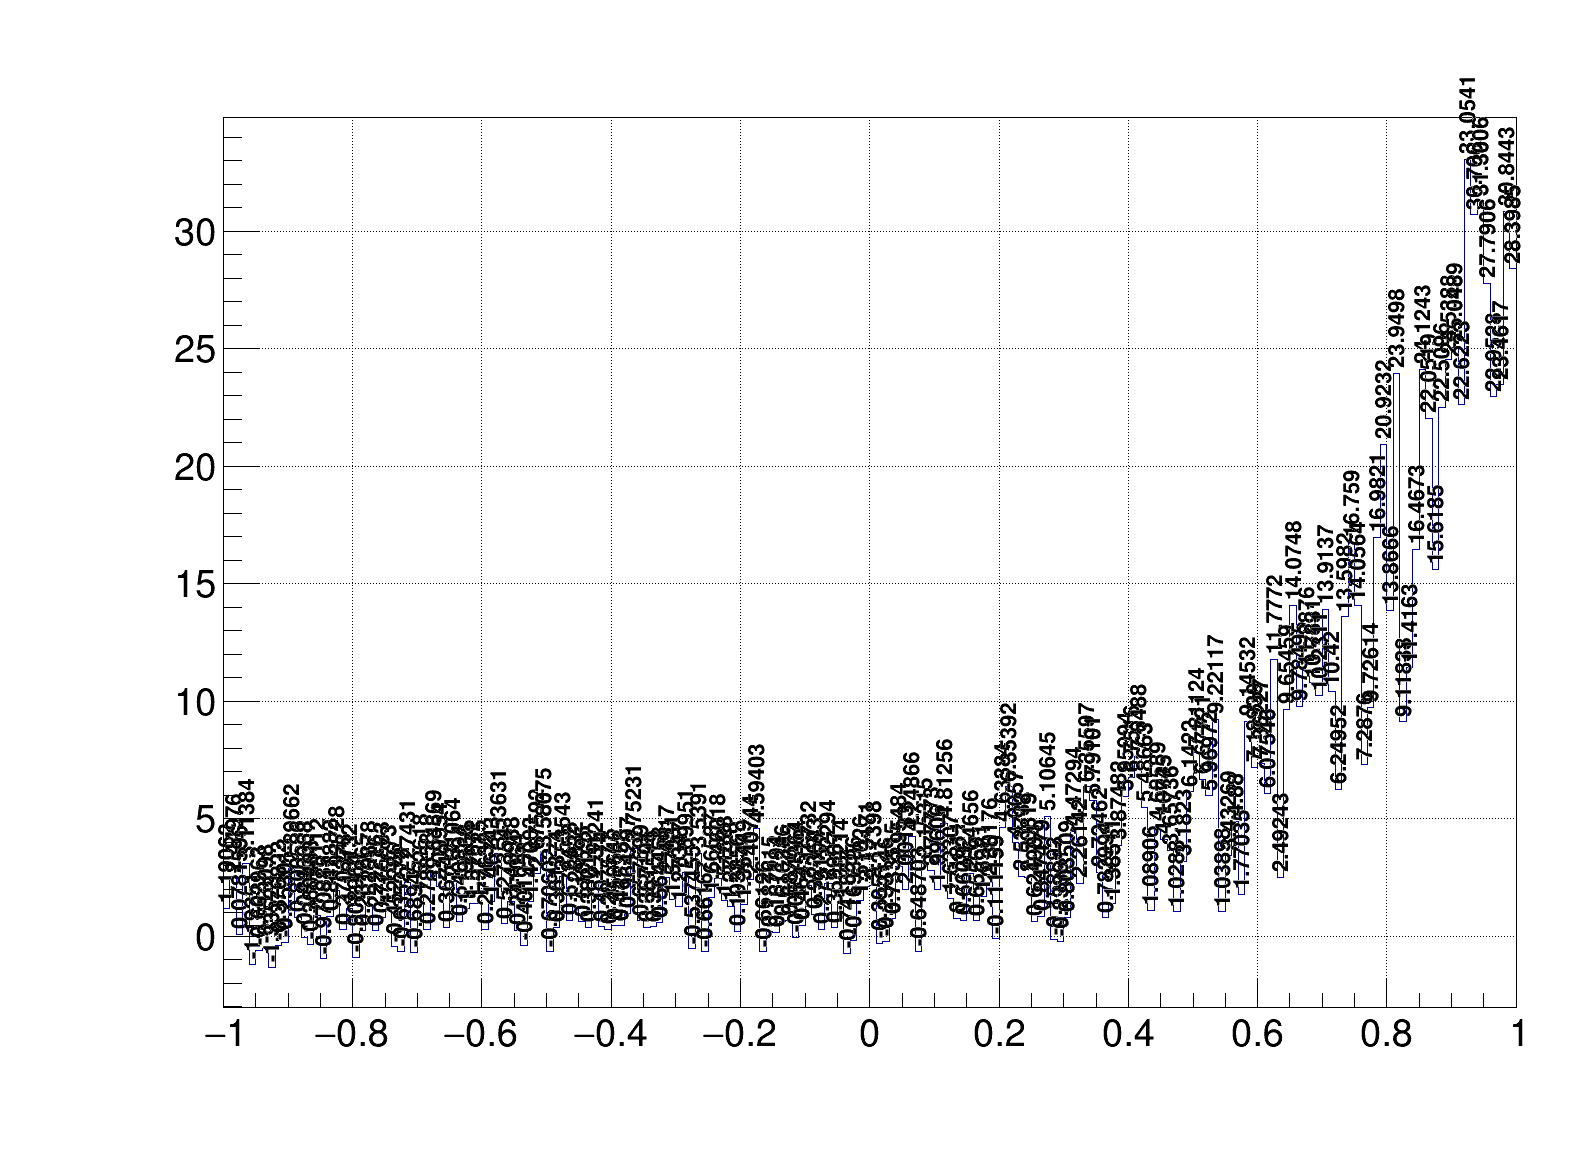

In [23]:
h_test.Draw('hist text')
c1.Draw()

In [24]:
h_true = ROOT.TH1F('h_true','h_true',binnum,array('f',mom_bins))
globale.overlay_out.Draw('cos(MCNu_leptonTheta)>>h_true',weight_name+'*(1 && numu_true)')


242327L

In [25]:
f = ROOT.TF1("my_distribution", my_distribution, -1, 1, binnum)
f.SetParameters(np.ones((binnum)))
for i in range (binnum):
    f.SetParLimits(i,0.0, h_true.GetBinContent(i+1)*50000);
result = h_test.Fit(f,'WL')

print f.GetParameters()[0]

0.0108638548598

****************************************
         Invalid FitResult  (status = 4 )
****************************************
Minimizer is Minuit / Migrad
MinFCN                    =      138.191
Chi2                      =       1889.3
NDf                       =          191
Edm                       =    0.0103656
NCalls                    =          280
p0                        =    0.0108639   +/-   0.0018845    	 (limited)
p1                        =   0.00774693   +/-   0.0011374    	 (limited)
p2                        =   0.00655158   +/-   0.000985918  	 (limited)
p3                        =   0.00598368   +/-   0.000906283  	 (limited)
p4                        =   0.00518006   +/-   0.000730252  	 (limited)
p5                        =   0.00663615   +/-   0.000656227  	 (limited)
p6                        =    0.0056537   +/-   0.000572868  	 (limited)
p7                        =   0.00597228   +/-   0.000587493  	 (limited)
p8                        =   0.0

Warning in <Fit>: Abnormal termination of minimization.


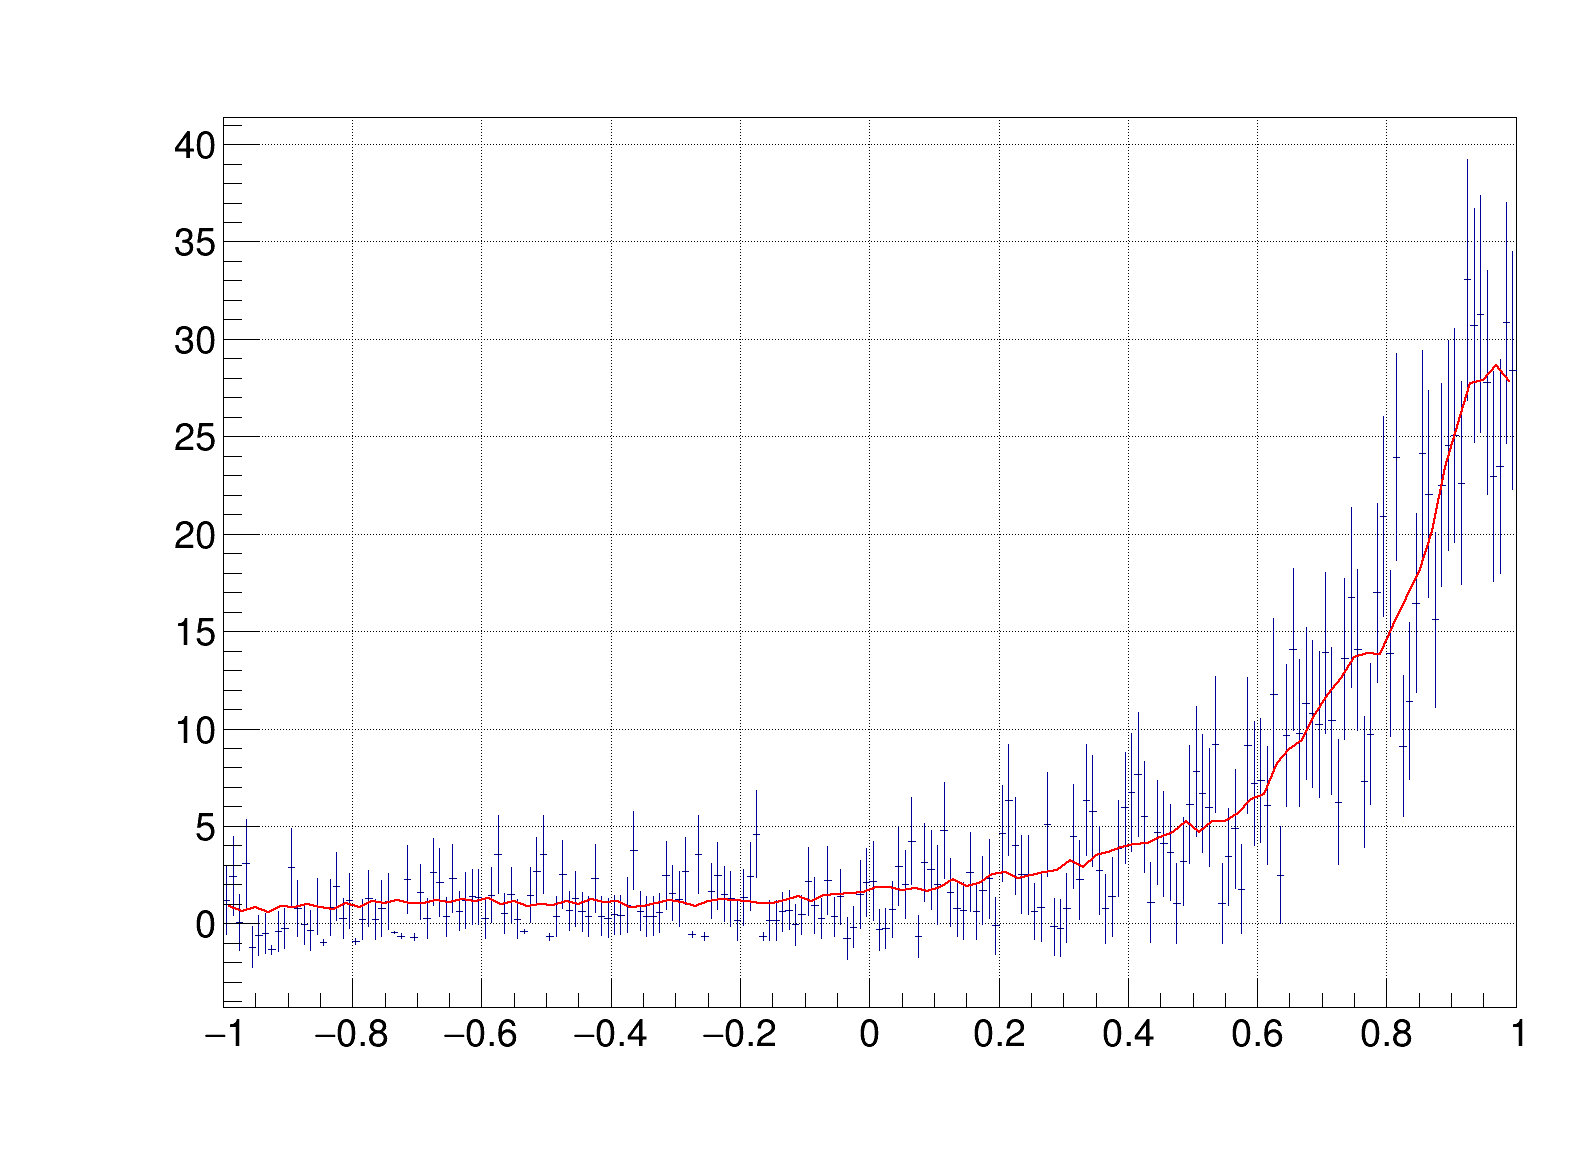

In [26]:
h_test.Draw()
f.Draw('same')
c1.Draw()

In [27]:
h_true = ROOT.TH1F('h_true','h_true',binnum,array('f',mom_bins))
globale.overlay_out.Draw('cos(TrackTheta)>>h_true',weight_name+'*('+cut+')')

166128L

Warning in <TFile::Append>: Replacing existing TH1: h_true (Potential memory leak).


5253.77294165 0.0108638548598 9685.30859375
7950.87508845 0.00774693466213 10439.1708984
8865.32035446 0.00655158225698 11849.5585938
11393.5941933 0.00598367948233 14374.7226562
16258.1890933 0.00518005830541 19919.3378906
22634.479648 0.00663614529062 26816.015625
27513.6861588 0.00565370120308 31298.9511719
28646.917559 0.00597228273962 32905.4296875
32836.9408097 0.00553885916234 37215.5273438


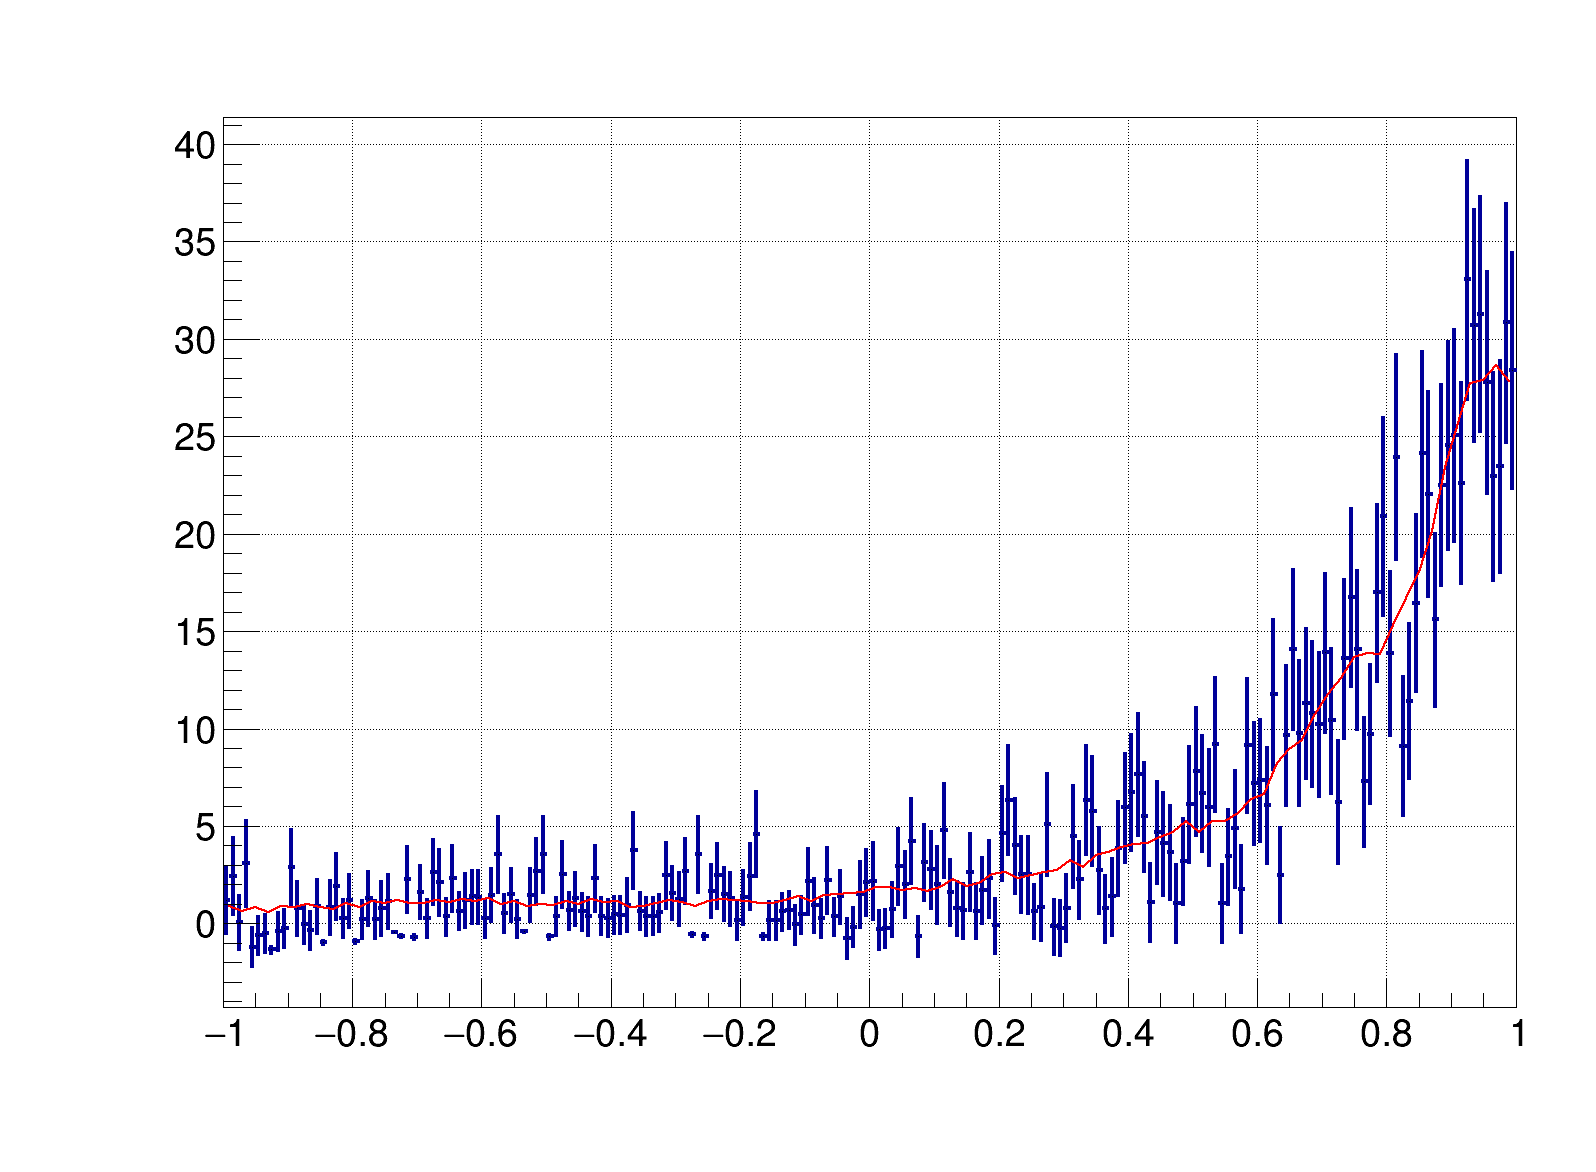

In [28]:
h_true_fit = ROOT.TH1F('h_true_fit','h_true_fit',binnum,array('f',mom_bins))
h_true_fit.SetLineColor(ROOT.kGreen)
for i in range(binnum):
    #print i,  h_temp[i].GetSumOfWeights(),  h_temp[i].Integral(0,binnum+1)
    #h_tmp = h_temp[i].Clone()
    #h_tmp.Scale(f.GetParameters()[i])
    #h_true_fit.Add(h_tmp)
    
    
    
    num_true = h_temp[i].GetSumOfWeights() #Integral(0,binnum)
    fit_scale = f.GetParameters()[i]
    print num_true, fit_scale, h_true.GetBinContent(i+1)
    h_true_fit.SetBinContent(i+1,num_true*fit_scale)
h_test.SetLineWidth(4)
h_test.Draw('')
h_true_fit.Draw('same')
c1.Draw()

In [29]:
a = [1,2,3]
b = [10,20,30]
print np.dot(a,b)

140


In [30]:
# Nselected and N generated
title = 'MCS momentum efficiency'
weight_name = 'EventWeight*TunedCentralValue_Genie'
nenner_cut = 'numu_true'
zahler_cut = 'fidVol && muon && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1 && numu_signal'
h_init_eff_energy = ROOT.TH1F("h_init_eff_energy",title,binnum,array('f',mom_bins))
h_init_eff_energy_1 = ROOT.TH1F("h_init_eff_energy_1",title,binnum,array('f',mom_bins))
globale.overlay_out.Draw('cos(MCNu_leptonTheta)>>h_init_eff_energy',weight_name+'*('+zahler_cut+')')
globale.overlay_out.Draw('cos(MCNu_leptonTheta)>>h_init_eff_energy_1',weight_name+'*('+nenner_cut+')')

#h_init_eff_energy.Write("h_eff_true_energy_z")
#h_init_eff_energy_1.Write("h_eff_true_energy_n")

242327L

In [31]:
h_eff_true = h_init_eff_energy.Clone()
h_eff_true.Divide(h_init_eff_energy_1)

True

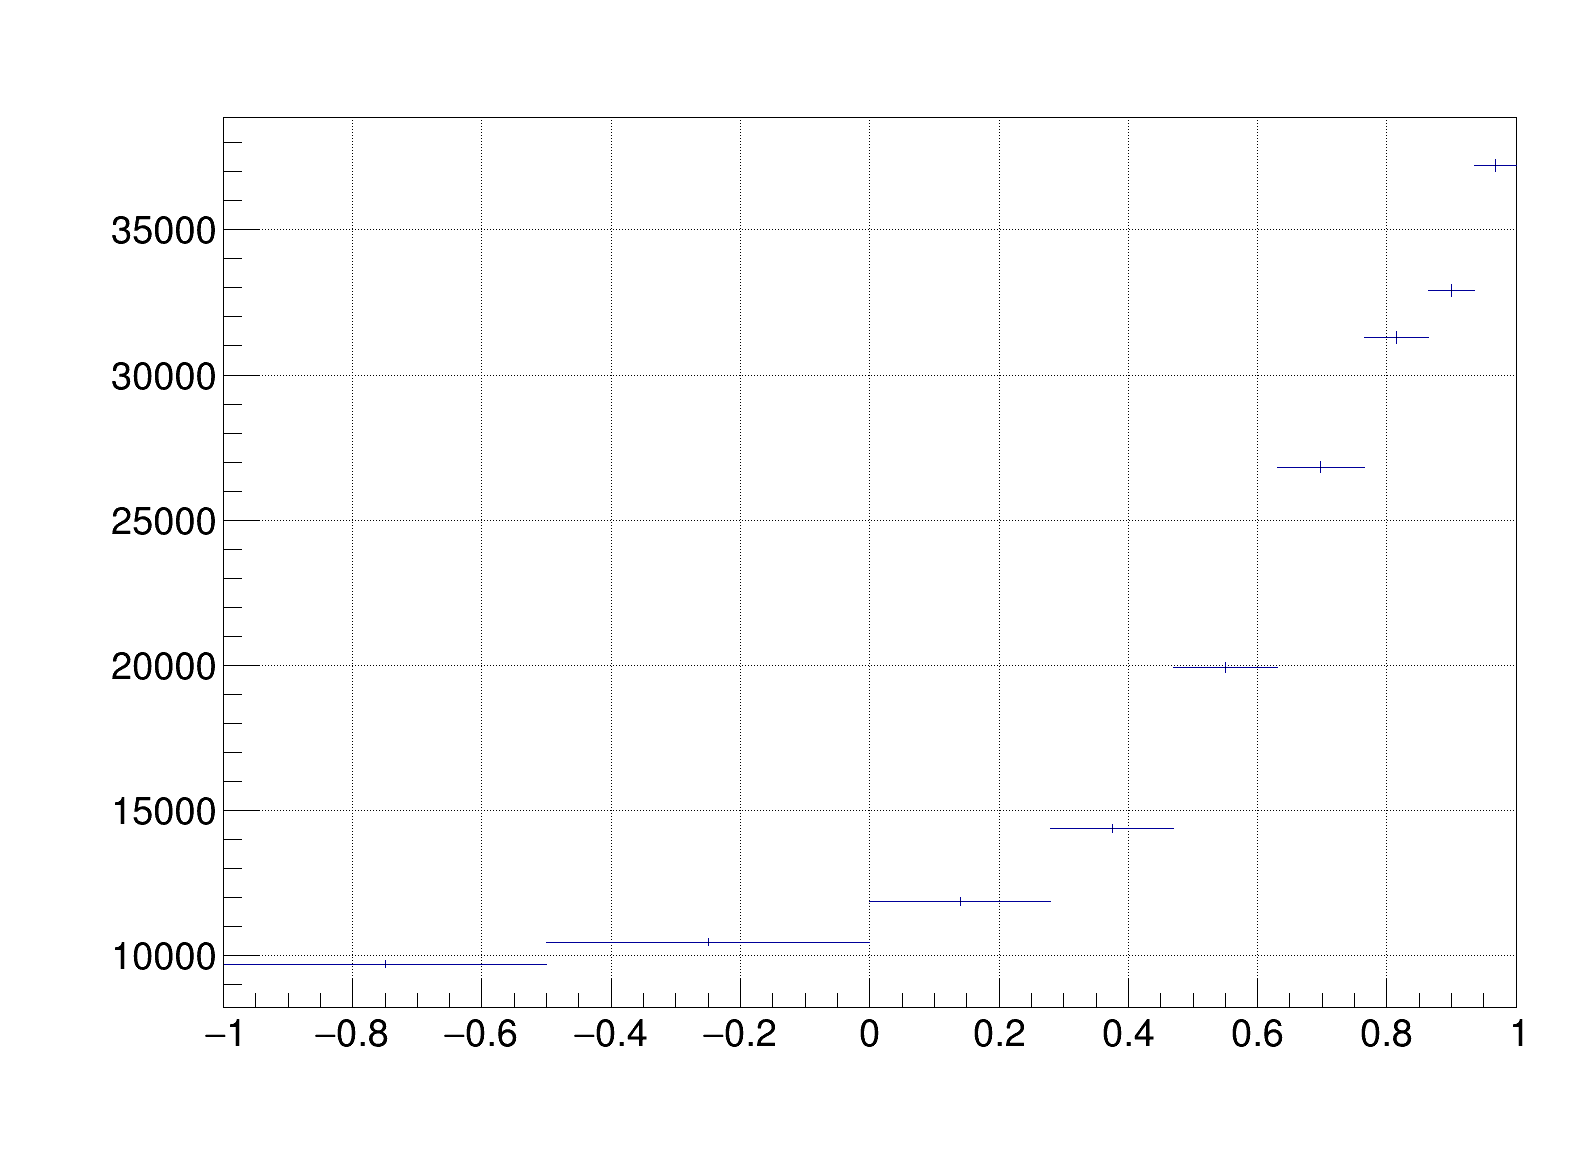

In [32]:
h_true.Draw()
c1.Draw()

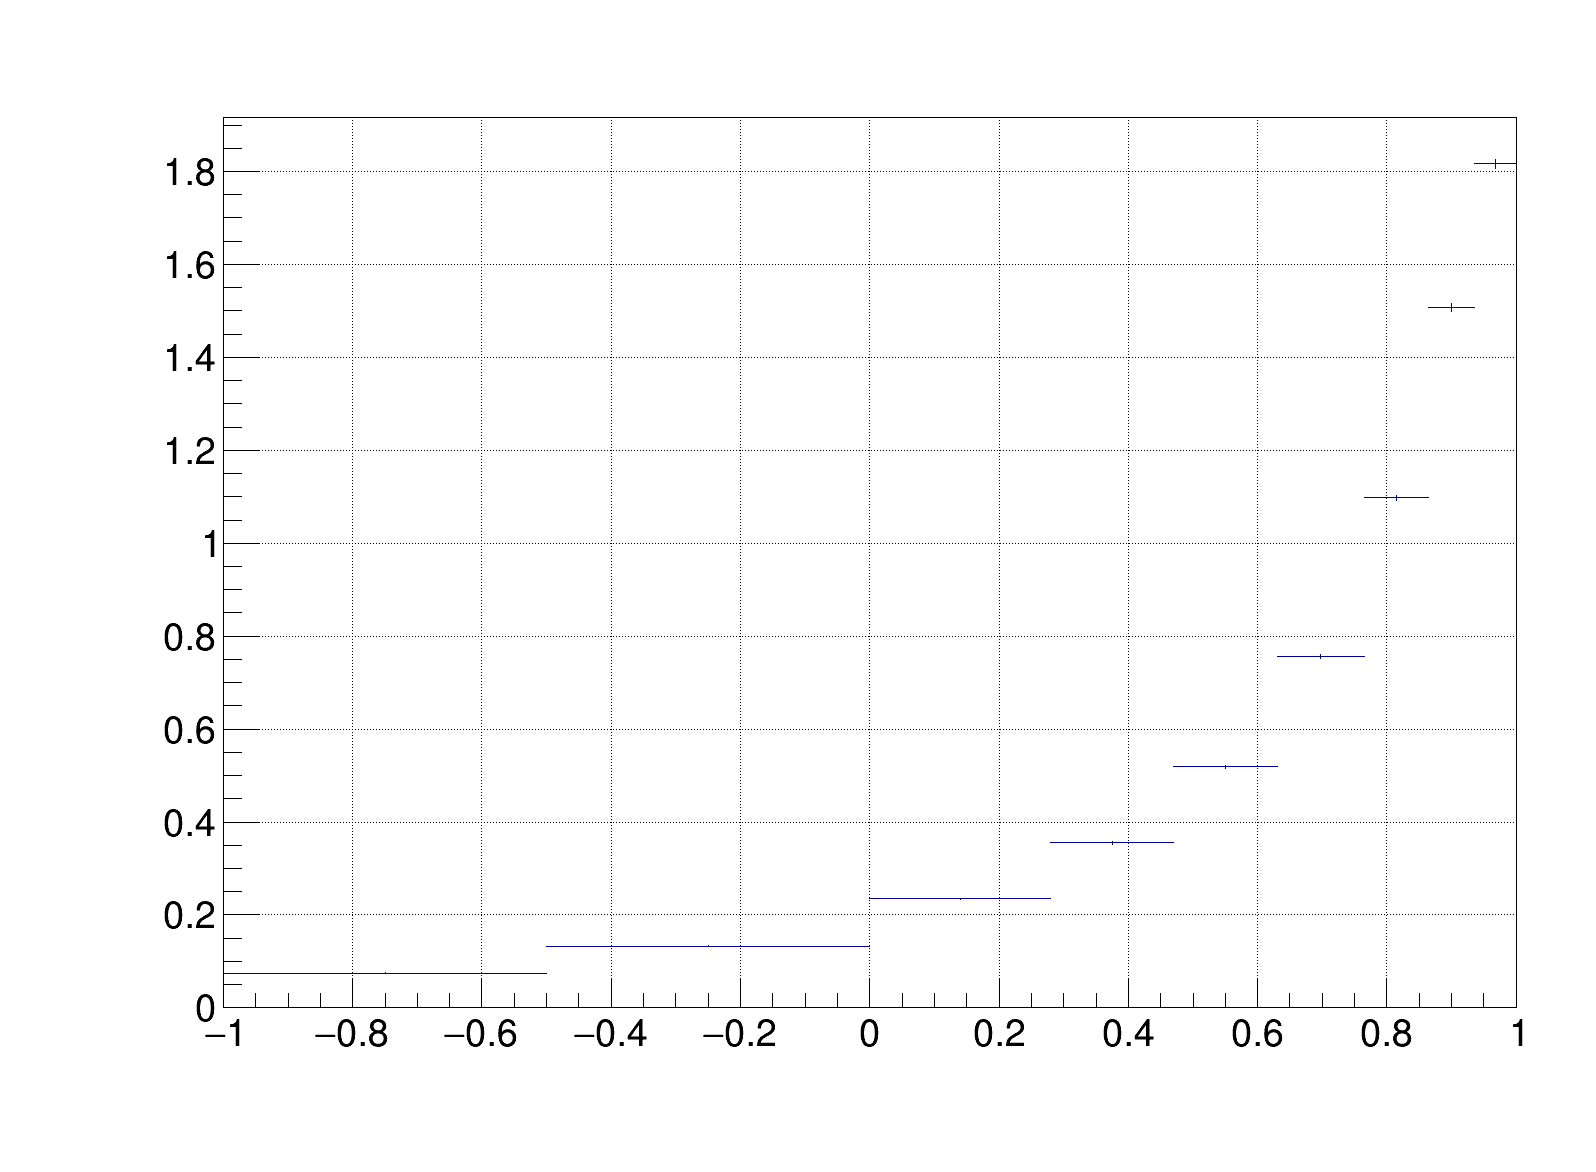

In [33]:
h_true_t = h_init_eff_energy_1.Clone()
h_true_t.Scale(scale[overlay])
h_true_t.Scale(1.0/(N_tot*beam_flux*1e-38))
#h_true_t.Divide(h_eff_true)
for i in range(1,binnum+1):
    h_true_t.SetBinContent(i,h_true_t.GetBinContent(i)/h_true_t.GetBinWidth(i))
    h_true_t.SetBinError(i,h_true_t.GetBinError(i)/h_true_t.GetBinWidth(i))
h_true_t.Draw()
c1.Draw()

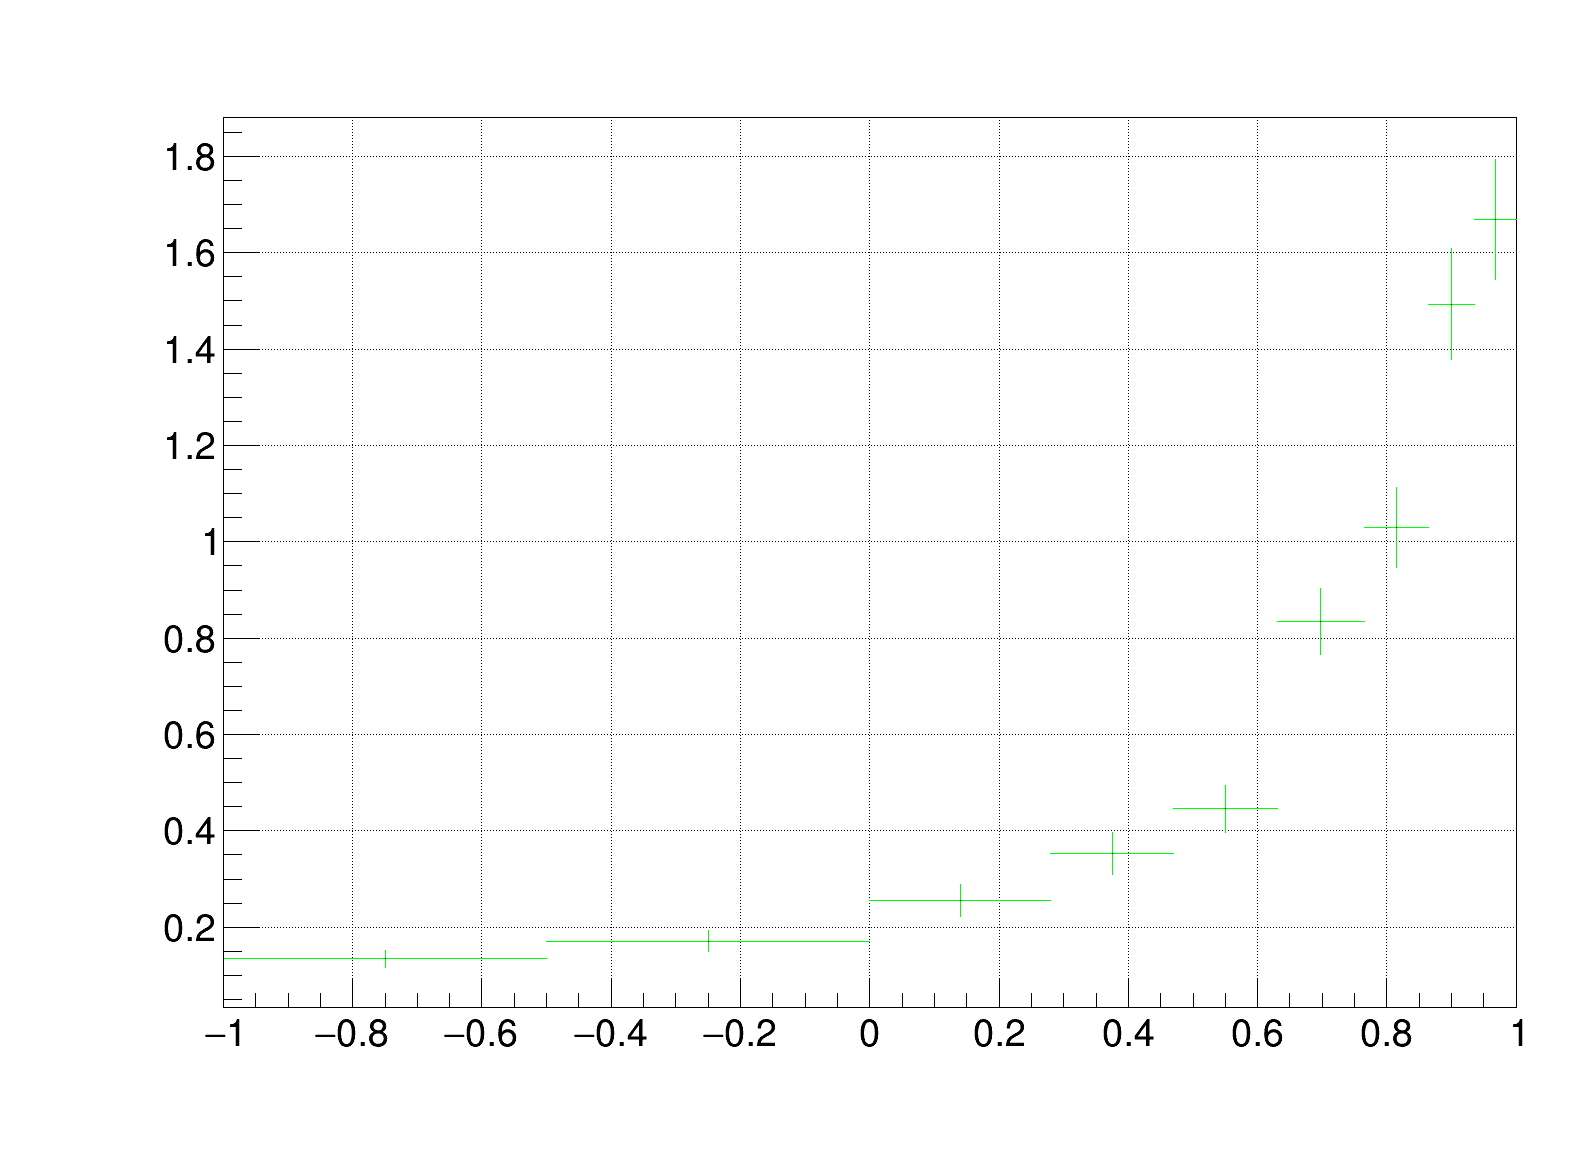

In [34]:
h_true_fit_t = h_true_fit.Clone()
h_true_fit_t.Scale(1.0/(N_tot*beam_flux*1e-38))
h_true_fit_t.Divide(h_eff_true)
for i in range(1,binnum+1):
    h_true_fit_t.SetBinContent(i,h_true_fit_t.GetBinContent(i)/h_true_fit_t.GetBinWidth(i))
    h_true_fit_t.SetBinError(i,h_true_fit_t.GetBinError(i)/h_true_fit_t.GetBinWidth(i))

h_true_fit_t.Draw()
c1.Draw()

521

Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_fit/png/h_xsec_corr.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_fit/root/h_xsec_corr.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_fit/pdf/h_xsec_corr.pdf has been created


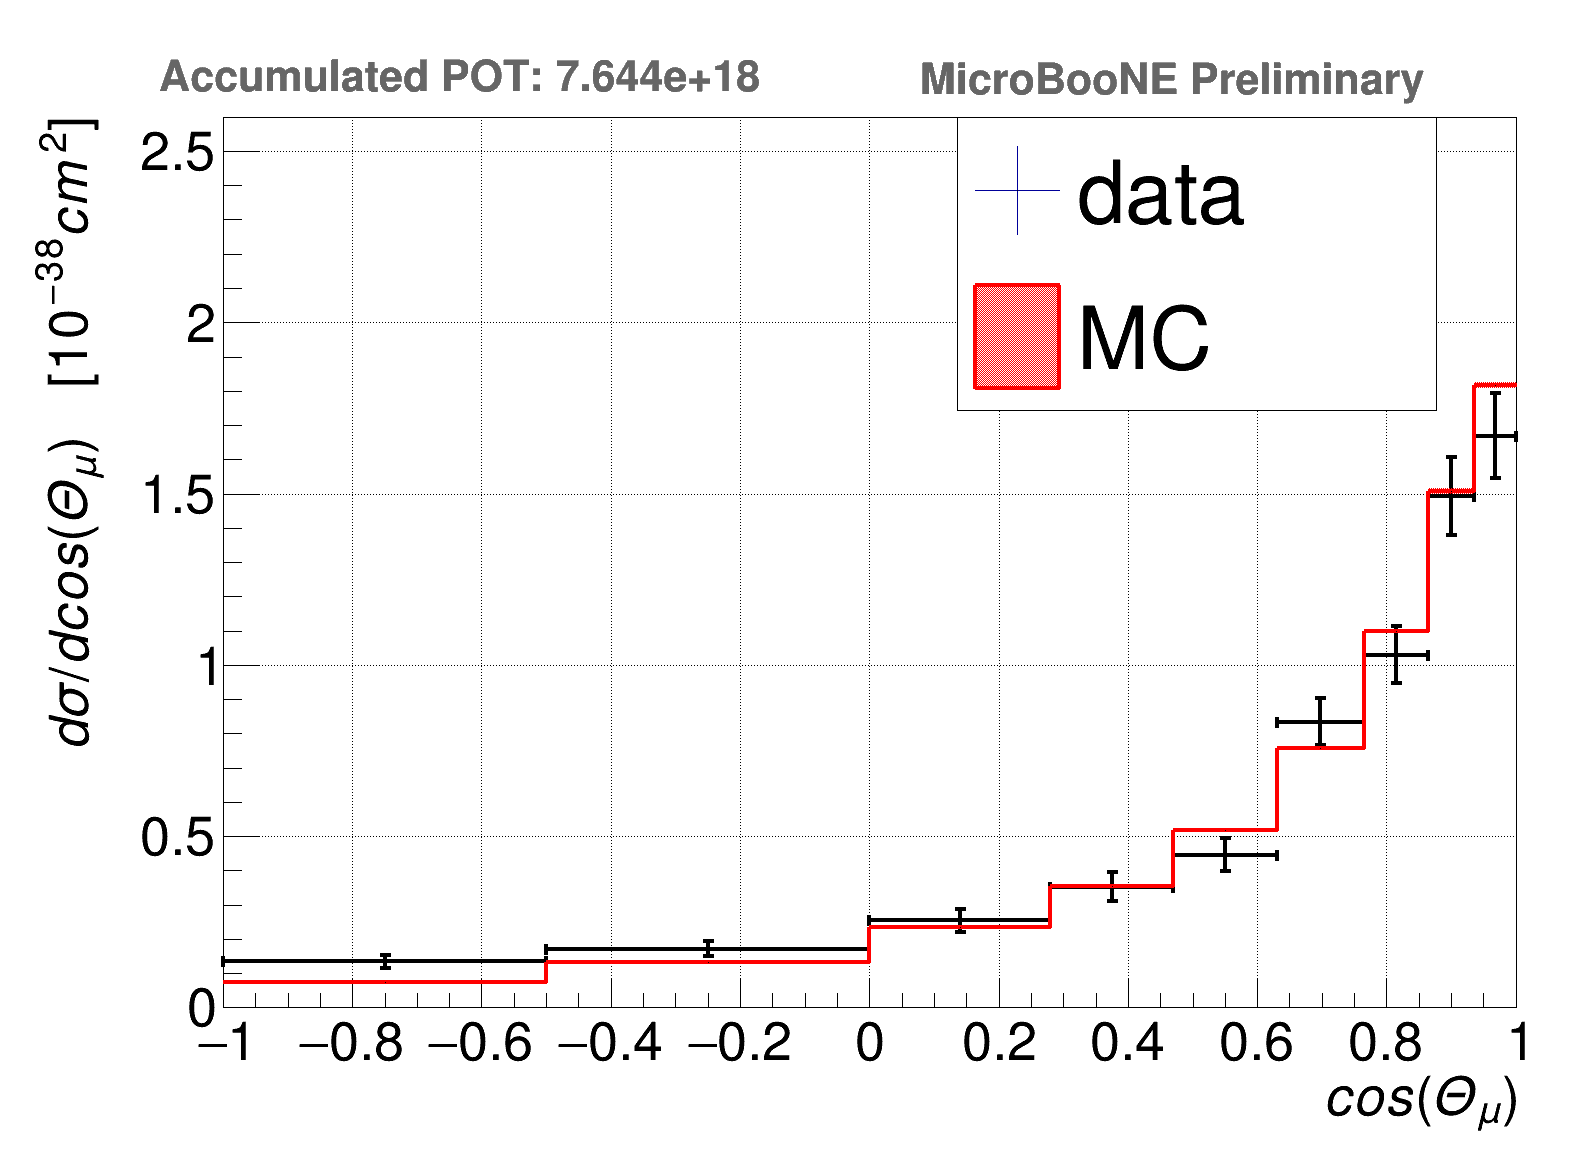

In [35]:
legend = ROOT.TLegend(0.6,0.65,0.9,0.9)
legend.AddEntry(h_data,'data',"lep");
legend.AddEntry(h_true_t,'MC',"f");
h_true_fit_t.SetYTitle("d\sigma / dcos(\Theta_{\mu}) \t [10^{-38} cm^{2}]")
h_true_fit_t.SetXTitle("cos(\Theta_{\mu})")
h_true_fit_t.SetLineWidth(3)
h_true_fit_t.SetMaximum(2.6)

h_true_fit_t.GetYaxis().SetTitleSize(0.05)
h_true_fit_t.GetYaxis().SetTitleOffset(0.0)
h_true_fit_t.GetYaxis().SetLabelSize(0.05)
h_true_fit_t.GetXaxis().SetTitleSize(0.05)
h_true_fit_t.GetXaxis().SetLabelSize(0.05)
h_true_fit_t.GetXaxis().SetTitleOffset(1)
h_true_fit_t.SetLineColor(ROOT.kBlack)
h_true_fit_t.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.05)

h_true_fit_t.Draw('E1')
h_true_t.SetLineColor(2)
h_true_t.SetFillColor(0)
h_true_t.SetLineWidth(4)
#h_true_t.Draw('hist same')
h_true_t.DrawCopy('Hist same')
h_true_t.SetFillColor(2)
h_true_t.SetFillStyle(3001)
h_true_t.Draw('E2 same')

legend.Draw()
prelim, pot_tex = draw_adding()
prelim.Draw()
pot_tex.Draw()
c1.Draw()
c1.SaveAs(globale.outputdir_png + "h_xsec_corr.png")
c1.SaveAs(globale.outputdir_root + "h_xsec_corr.root")
c1.SaveAs(globale.outputdir_pdf + "h_xsec_corr.pdf")

h_true_fit_t.Write("h_xsec_data")
h_true_t.Write("h_xsec_MC")


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_fit/png/h_xsec_corr_ratio.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_fit/root/h_xsec_corr_ratio.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_fit/pdf/h_xsec_corr_ratio.pdf has been created


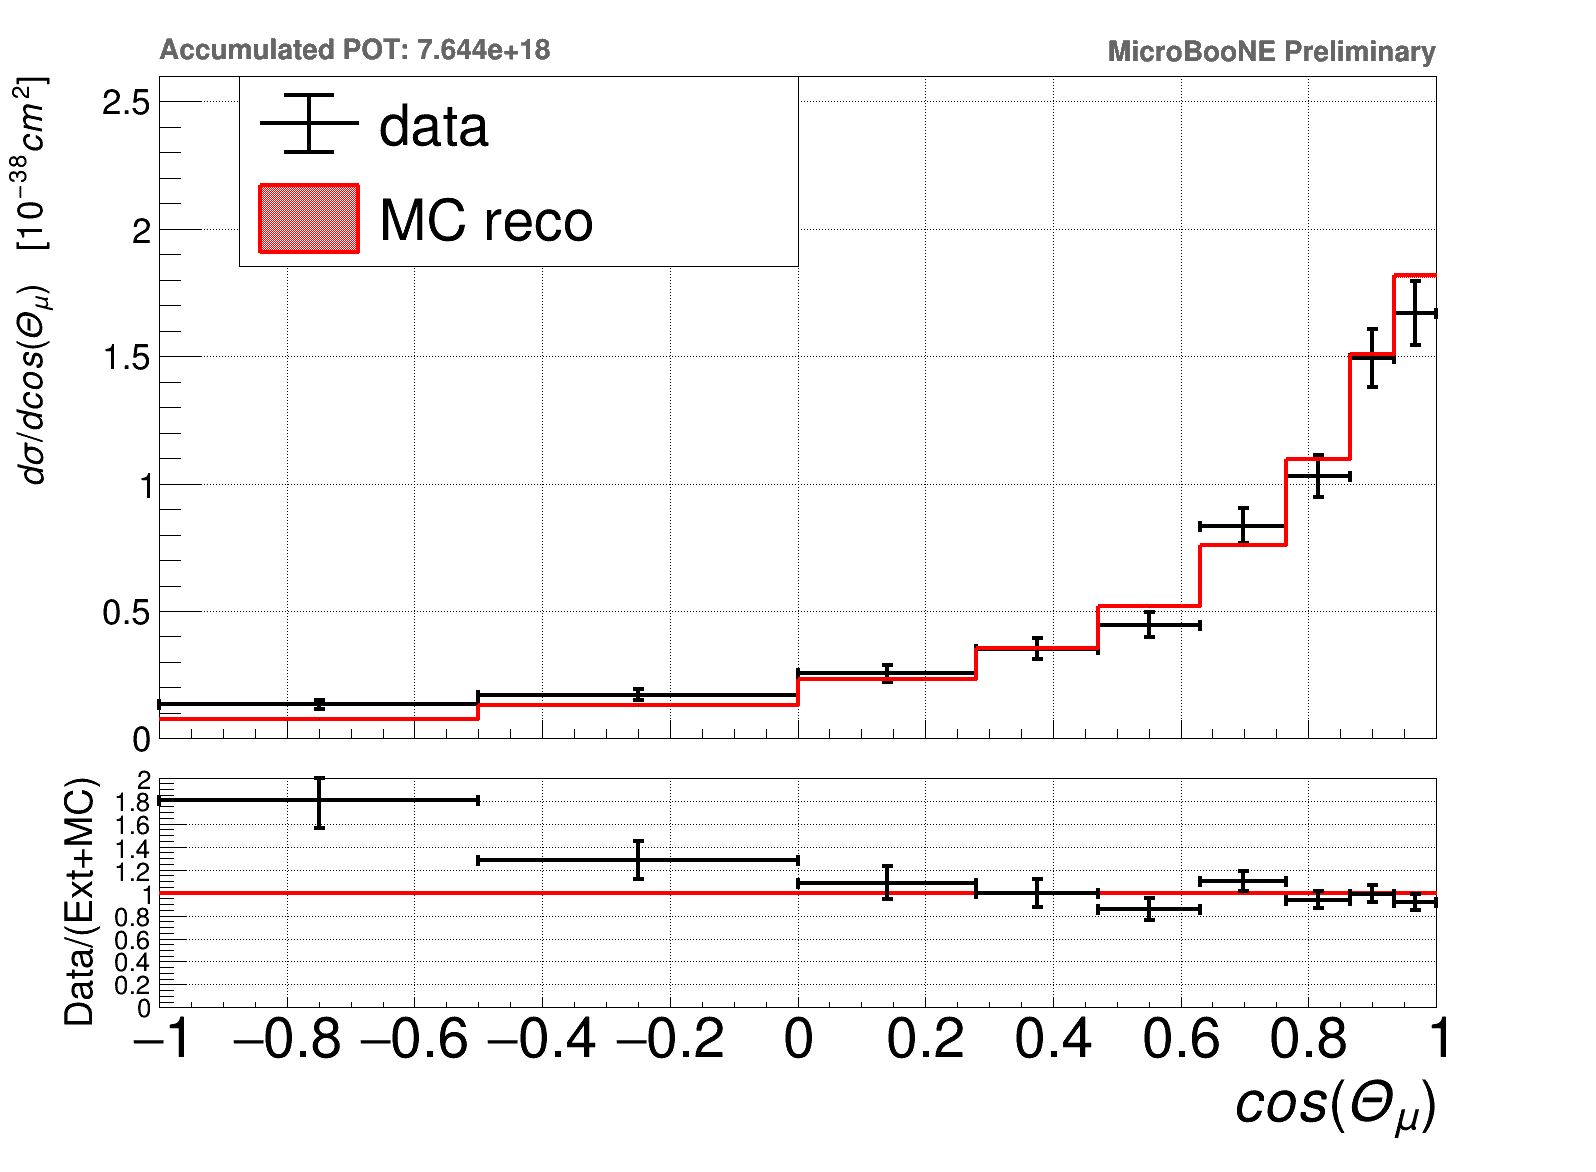

In [36]:
h_data = h_true_fit_t.Clone()
h_overlay_sig = h_true_t.Clone()

legend = ROOT.TLegend(0.15,0.65,0.5,0.9)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.1)
c1.SetBottomMargin(0.1)
#c1.SetFillStyle(4000);
# first pad
c1.cd()
pad1 = ROOT.TPad('pad1','pad1',0,0.35,1,1)
pad1.SetGrid(1)
pad1.Draw()
pad1.cd()
pad1.SetBottomMargin(0.03);
pad1.SetTopMargin(0.1)

h_overlay_sig.SetLineColor(2)
legend.AddEntry(h_data,'data',"lep");
legend.AddEntry(h_overlay_sig,'MC reco',"f");

h_data.SetYTitle("d\sigma / dcos(\Theta_{\mu}) \t [10^{-38} cm^{2}]")
h_data.SetXTitle("cos(\Theta_{\mu})")
h_data.SetLineWidth(3)
h_data.SetMaximum(2.6)

h_data.GetYaxis().SetTitleSize(0.05)
h_data.GetYaxis().SetTitleOffset(0.0)
h_data.GetYaxis().SetLabelSize(0.05)
h_data.GetXaxis().SetTitleSize(0.05)
h_data.GetXaxis().SetLabelSize(0.05)
h_data.GetXaxis().SetTitleOffset(1)
h_data.SetLineColor(ROOT.kBlack)
h_data.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.05)

h_data.GetXaxis().SetLabelOffset(999);
h_data.GetXaxis().SetTitleOffset(999);
h_data.GetXaxis().SetLabelSize(0);
h_data.GetXaxis().SetTitleSize(0);

h_data.Draw('E1')
h_overlay_sig.SetFillColor(0)
h_overlay_sig.SetLineWidth(4)
#h_overlay_sig.Draw('hist same')
h_overlay_sig.DrawCopy('Hist same')
h_overlay_sig.SetFillColor(2)
h_overlay_sig.SetFillStyle(3001)
h_overlay_sig.Draw('E2 same')

legend.Draw()
prelim, pot_tex = draw_adding()
prelim.Draw()
pot_tex.Draw()

c1.cd()
h_data.GetXaxis().SetLabelOffset(0);
h_data.GetXaxis().SetTitleOffset(0);

pad2 = ROOT.TPad('pad2','pad2',0,0,1,0.35)
pad2.SetGrid(1)
pad2.SetTopMargin(0.04)
pad2.SetBottomMargin(0.4)
pad2.Draw()
pad2.cd()

h_overlay_sig_ratio = h_overlay_sig.Clone()
h_overlay_sig_ratio.Divide(h_overlay_sig)
h_overlay_data_ratio = h_data.Clone()
h_overlay_data_ratio.Divide(h_overlay_sig)

h_overlay_data_ratio.SetMinimum(0.0)
h_overlay_data_ratio.SetMaximum(2.0)
h_overlay_sig_ratio.SetFillColor(0)
h_overlay_data_ratio.SetYTitle('Data/(Ext+MC)')
h_overlay_data_ratio.GetYaxis().SetTitleSize(0.1)
h_overlay_data_ratio.GetYaxis().SetTitleOffset(0.3)
h_overlay_data_ratio.GetYaxis().SetLabelSize(0.07)
h_overlay_data_ratio.GetXaxis().SetTitleSize(0.15)
h_overlay_data_ratio.GetXaxis().SetLabelSize(0.15)
h_overlay_data_ratio.GetXaxis().SetTitleOffset(1)

h_overlay_data_ratio.Draw('E1')
h_overlay_sig_ratio.Draw('same hist')
h_overlay_data_ratio.Draw('E1 same')


c1.Draw()
c1.SaveAs(globale.outputdir_png + "h_xsec_corr_ratio.png")
c1.SaveAs(globale.outputdir_root + "h_xsec_corr_ratio.root")
c1.SaveAs(globale.outputdir_pdf + "h_xsec_corr_ratio.pdf")

#h_data.Write("h_xsec_data")
#h_overlay_sig.Write("h_xsec_MC")

In [37]:
# close the root file with all the histos
RootFile.Close()